In [2]:
import yfinance as yf
import numpy as np
import tvgl
import matplotlib.pyplot as plt
import pandas as pd  
import networkx as nx


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed


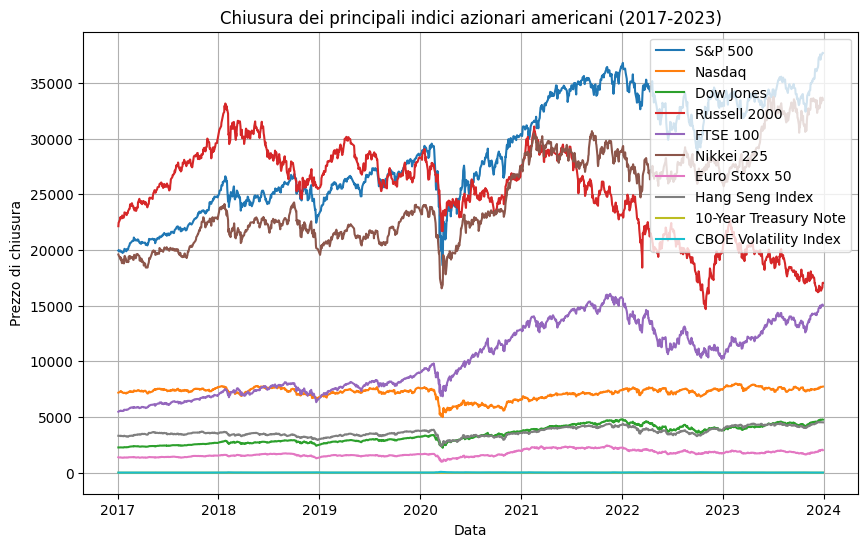

In [ ]:

# Lista degli indici azionari
indices = ['^GSPC', '^IXIC', '^DJI', '^RUT', '^FTSE', '^N225', '^STOXX50E', '^HSI', '^TNX', '^VIX']


# Periodi di interesse
start_date_pre_covid = '2017-01-01'
end_date_pre_covid = '2019-12-31'

start_date_covid = '2020-01-01'
end_date_covid = '2021-12-31'

start_date_post_covid = '2022-01-01'
end_date_post_covid = '2023-12-31'

# Funzione per scaricare i dati di chiusura
def download_data(indices, start_date, end_date):
    data = yf.download(indices, start=start_date, end=end_date)['Close']
    return data

# Scarica i dati
data_pre_covid = download_data(indices, start_date_pre_covid, end_date_pre_covid)
data_covid = download_data(indices, start_date_covid, end_date_covid)
data_post_covid = download_data(indices, start_date_post_covid, end_date_post_covid)

# Combina i dati
data_combined = pd.concat([data_pre_covid, data_covid, data_post_covid], axis=0)

# Aggiusta i dati (opzionale, ad esempio rimuovendo NaN o normalizzando)
data_combined = data_combined.dropna()  # Rimuovi eventuali NaN

# Visualizza i grafici
plt.figure(figsize=(10, 6))
for col in data_combined.columns:
    plt.plot(data_combined.index, data_combined[col], label=col)
plt.title('Chiusura dei principali indici azionari americani (2017-2023)')
plt.xlabel('Data')
plt.ylabel('Prezzo di chiusura')
plt.legend(labels=['S&P 500', 'Nasdaq', 'Dow Jones', 'Russell 2000', 'FTSE 100', 'Nikkei 225', 'Euro Stoxx 50', 'Hang Seng Index', '10-Year Treasury Note', 'CBOE Volatility Index'])
plt.grid(True)
plt.show()

Diff before and during COVID: 1.6612226219715276
Diff during and after COVID: 1.6255404082761058


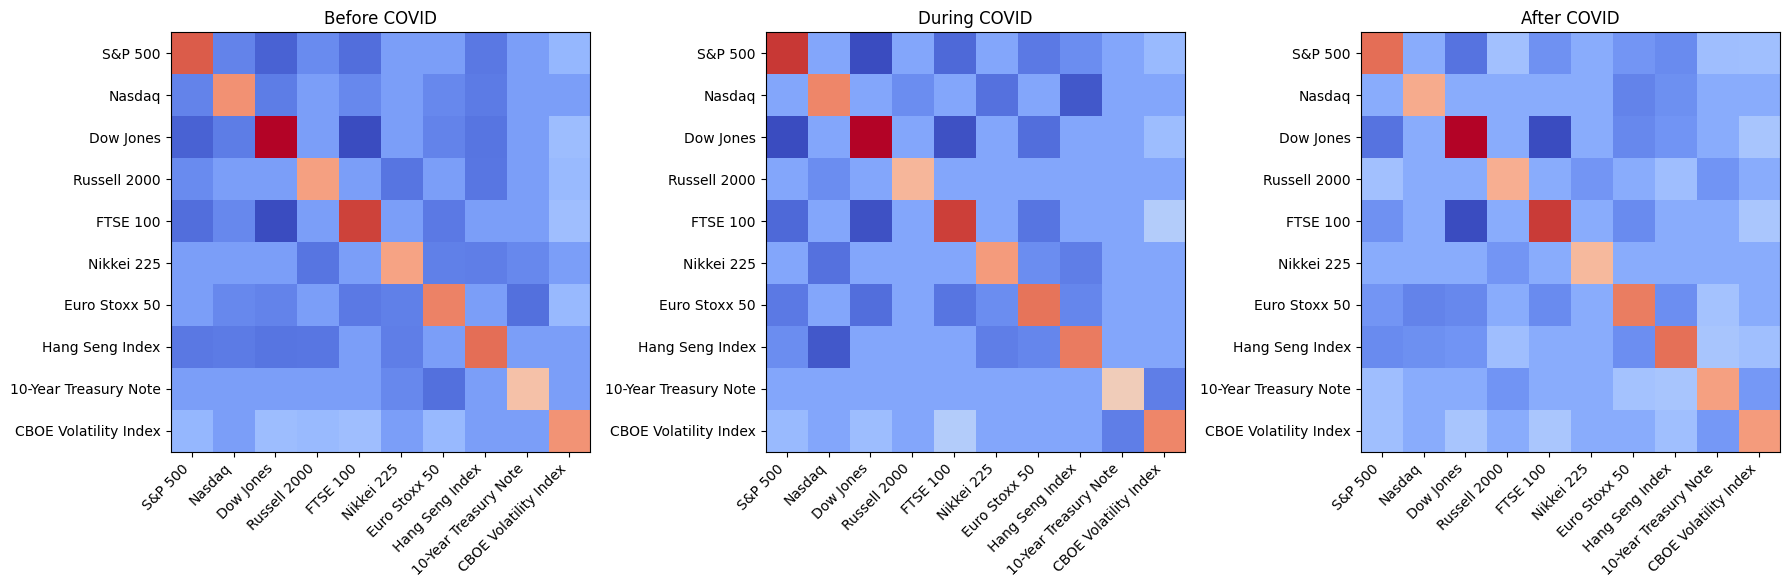

In [12]:
# Supponiamo che tu abbia una lista con i nomi degli indici (sostituisci con i nomi reali)
index_names = ['S&P 500', 'Nasdaq', 'Dow Jones', 'Russell 2000', 'FTSE 100', 'Nikkei 225', 'Euro Stoxx 50', 'Hang Seng Index', '10-Year Treasury Note', 'CBOE Volatility Index']

data = data_combined.values

# Definisci i periodi (prima, durante e dopo il Covid)
before_covid = data[:int(len(data)*0.4)]  # 40% prima del Covid
during_covid = data[int(len(data)*0.4):int(len(data)*0.8)]  # 40% durante il Covid
after_covid = data[int(len(data)*0.8):]  # 20% dopo il Covid

# Imposta i parametri per TVGL
alpha = 7
beta = 3
penalty_type = "L2"
slice_size = 50

# Crea il modello TVGL
model_before = tvgl.TVGL(alpha, beta, penalty_type, slice_size)
model_during = tvgl.TVGL(alpha, beta, penalty_type, slice_size)
model_after = tvgl.TVGL(alpha, beta, penalty_type, slice_size)

# Allena i modelli sui rispettivi dati
model_before.fit(before_covid)
model_during.fit(during_covid)
model_after.fit(after_covid)

# Confronta le matrici di precisione tra i periodi
precision_before = model_before.precision_set
precision_during = model_during.precision_set
precision_after = model_after.precision_set

# Calcola la differenza tra le matrici di precisione
def frobenius_norm(A, B):
    return np.linalg.norm(A - B, 'fro')

# Esegui il calcolo della norma Frobenius per ogni periodo
diff_before_during = frobenius_norm(precision_before[-1], precision_during[-1])
diff_during_after = frobenius_norm(precision_during[-1], precision_after[-1])

print(f"Diff before and during COVID: {diff_before_during}")
print(f"Diff during and after COVID: {diff_during_after}")

# Imposta la tolleranza per i valori deboli
tolerance = 0.15  # Puoi cambiare questa tolleranza

# Funzione per applicare la tolleranza alla matrice di precisione
def apply_tolerance(matrix, tolerance):
    matrix = np.array(matrix)
    matrix[np.abs(matrix) < tolerance] = 0
    return matrix

# Visualizza i grafici per ciascun periodo
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Funzione per plot grafico
def plot_graph(matrix, ax, title):
    ax.imshow(matrix, cmap='coolwarm', interpolation='nearest')
    ax.set_title(title)
    ax.set_xticks(range(len(matrix)))
    ax.set_yticks(range(len(matrix)))
    
    # Usa i nomi degli indici come etichette sugli assi
    ax.set_xticklabels(index_names, rotation=45, ha="right")
    ax.set_yticklabels(index_names)

# Applica la tolleranza alle matrici di precisione e plottale
plot_graph(apply_tolerance(precision_before[-1], tolerance), axes[0], "Before COVID")
plot_graph(apply_tolerance(precision_during[-1], tolerance), axes[1], "During COVID")
plot_graph(apply_tolerance(precision_after[-1], tolerance), axes[2], "After COVID")

plt.tight_layout()
plt.show()


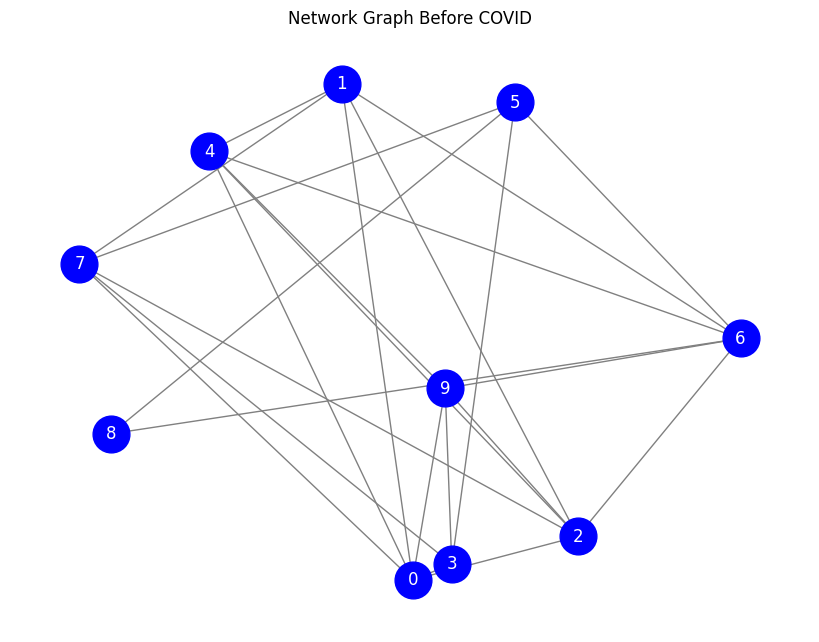

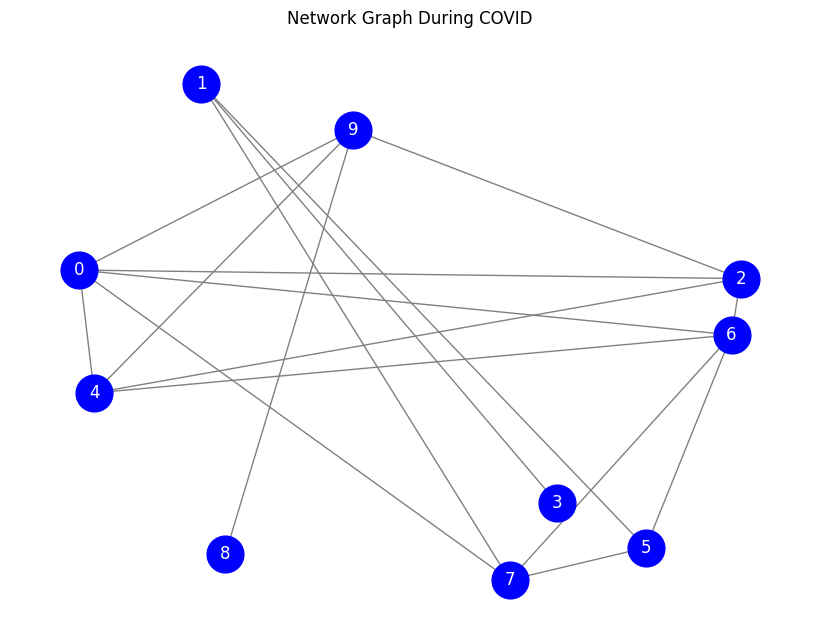

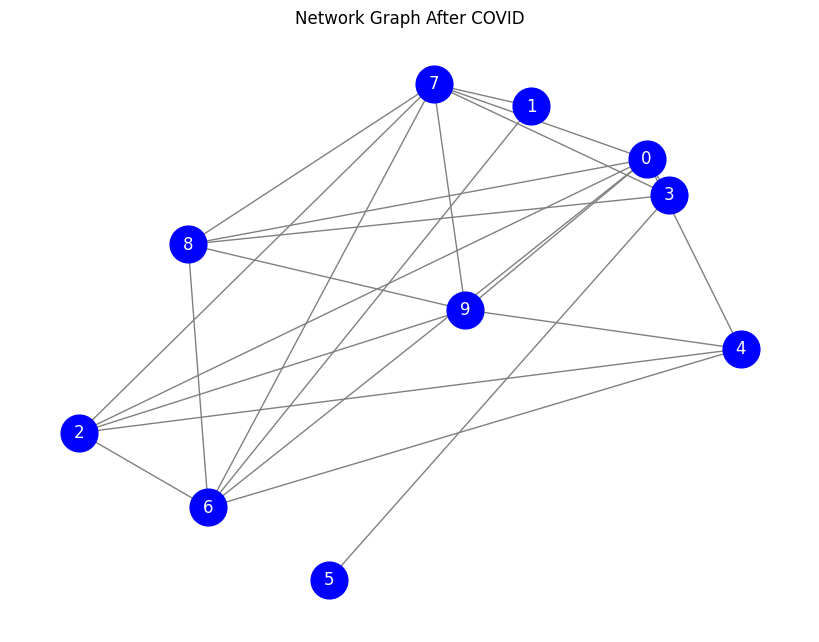

In [13]:
# Funzione per creare il grafo a partire dalla matrice di precisione
def create_graph_from_precision_matrix(matrix, tickers, tolerance):
    matrix = np.array(matrix)
    matrix[np.abs(matrix) < tolerance] = 0  # Applica la tolleranza

    # Crea il grafo
    graph = nx.Graph()

    # Aggiungi nodi e archi
    for i in range(matrix.shape[0]):
        for j in range(i + 1, matrix.shape[1]):
            if matrix[i, j] != 0:  # Considera solo le connessioni non zero
                graph.add_edge(i, j, weight=matrix[i, j])

    # Assicurati che tutti i nodi siano nel grafo, anche se non hanno archi
    for node in range(len(tickers)):
        if node not in graph:
            graph.add_node(node)
    
    return graph

# Funzione per visualizzare il grafo
def plot_network_graph(graph, tickers, title):
    fixed_pos = nx.spring_layout(graph)  # Layout dinamico per il grafo
    plt.figure(figsize=(8, 6))
    nx.draw(
        graph,
        pos=fixed_pos,
        with_labels=True,
        node_size=700,
        font_size=12,
        font_color="white",
        node_color="blue",
        width=1.0,
        edge_color="gray",
    )
    plt.title(title)
    plt.show()

# Creazione e visualizzazione dei grafi per ciascun periodo
tolerance = 0.15  # Tolleranza per connessioni deboli

# Crea e visualizza il grafo per "Before COVID"
graph_before = create_graph_from_precision_matrix(precision_before[-1], index_names, tolerance)
plot_network_graph(graph_before, index_names, "Network Graph Before COVID")

# Crea e visualizza il grafo per "During COVID"
graph_during = create_graph_from_precision_matrix(precision_during[-1], index_names, tolerance)
plot_network_graph(graph_during, index_names, "Network Graph During COVID")

# Crea e visualizza il grafo per "After COVID"
graph_after = create_graph_from_precision_matrix(precision_after[-1], index_names, tolerance)
plot_network_graph(graph_after, index_names, "Network Graph After COVID")
